In [116]:
######################################################### Imports #############################################################

import vrep
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [117]:
################################################## Conexão com o V-rep #######################################################

clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # Faz conexão, se retorna -1 é que deu erro

if clientID!=-1:
    print('Conexão sucedida')
else:
    print("Erro na conexão")

Erro na conexão


In [118]:
################################################ Declaração de Váriáveis ######################################################
   
    # Função np.arrange dá sequenência de numeros, dado umintervalo
    # ctrl.Antecedent descrita na documentação do scikit-fuzzy,idem à  ctrl.Consequent
    
## Valores Crisp
sensores_handle = []        #lista com os Handles dos sensores, para pegar os Handles mais fácil
valores_sensores = []       # Lista com os valores dos sensores


# Valores Fuzzy
    # Antecedentes: Váriaveis à serem Fuzificada
sensor_frente  = ctrl.Antecedent(np.arange(0,0.12, 0.01),'sensor_frente')  
sensores_left  = ctrl.Antecedent(np.arange(0,0.12, 0.01), 'sensores_left')
sensores_right = ctrl.Antecedent(np.arange(0,0.12, 0.01), 'sensores_right')

    # Consequentes
v_left  = ctrl.Consequent(np.arange(0, 10, 0.5), 'v_left')         # velocidade motor esquerdo, vai de 0 à 10 (eu determinei impiricamente na simulação)
v_right = ctrl.Consequent(np.arange(0, 10, 0.5), 'v_right')        # idem ao de cima pro motor direito

In [119]:
############################################ Declaração de Handles ############################################################

# Não sei direito o que é um handle até hoje, mas chutaria que ele é uma coisa que controla o objeto real

#handle do motor esquerdo, chuto que o nome do objeto seja o mesmo da simulação
erro_code, leftMotorHandle = vrep.simxGetObjectHandle(clientID,'KJunior_wheelLeft', vrep.simx_opmode_oneshot_wait )

#Handle do motor Direito
erro_code, rightMotorHandle = vrep.simxGetObjectHandle(clientID,'KJunior_wheelLeft', vrep.simx_opmode_oneshot_wait )

#Handle dos sensores, só importam os do 1 ao 5, o 3 é o sensor mais centralizado
for i in range(5):
    erro_code, sensor_handle = vrep.simxGetObjectHandle(clientID,'KJunior_proxSensor%d' % (i+1) , vrep.simx_opmode_oneshot_wait)
    sensores_handle.append(sensor_handle)

    # Não sei porque, mas a primeira leitura tem que ser assim
    error_code,estado,coord,detectedObjectHandle,detectedSurfaceNormalVector = vrep.simxReadProximitySensor(clientID, sensor_handle,vrep.simx_opmode_streaming)

In [120]:
############################################# Lógica Fuzzy ################################################################

## Funções de pertinencia (Também conhecidas como membership)
    # Fuzz.trimf faz uma função de pertinencia triangulas onde [x,y,z] são os pontos do triangulo
    
# Sensor da frente
sensor_frente['perto'] = fuzz.trimf(sensor_frente.universe, [0, 0, 0.065])
sensor_frente['longe'] = fuzz.trimf(sensor_frente.universe,[0.065,0.065,0.12])
                             
# Sensor do lado esquerdo
sensores_left['perto'] = fuzz.trimf(sensores_left.universe, [0, 0, 0.065])
sensores_left['longe'] = fuzz.trimf(sensores_left.universe,[0.065,0.065,0.12])

# Sensores do lado direito
sensores_right['perto'] = fuzz.trimf(sensores_right.universe, [0, 0, 0.065])
sensores_right['longe'] = fuzz.trimf(sensores_right.universe,[0.065,0.065,0.12])

# Velocidade Motor esquerdo 
v_left['parado'] = fuzz.trimf(v_left.universe, [0,0,0.1])
v_left['lento'] = fuzz.trimf(v_left.universe, [1,3,10])
v_left['rapido'] = fuzz.trimf(v_left.universe, [5,10,10])

# Velocidade motor direito
v_right['parado'] = fuzz.trimf(v_right.universe, [0,0,0.1])
v_right['lento'] = fuzz.trimf(v_right.universe, [1,3,10])
v_right['rapido'] = fuzz.trimf(v_right.universe, [5,10,10])

## Regras Fuzzy
regra1 = ctrl.Rule(sensor_frente['perto'] and sensores_left['perto'] and sensores_left['perto'], 
                   v_right['rapido'] and v_left['parado'] )

regra2 = ctrl.Rule(sensor_frente['perto'] and sensores_left['perto'] and sensores_left['longe'], 
                   v_right['parado'] and v_left['rapido'] )

regra3 = ctrl.Rule(sensor_frente['perto'] and sensores_left['longe'] and sensores_left['perto'], 
                   v_right['rapido'] and v_left['parado'] )

regra4 = ctrl.Rule(sensor_frente['longe'] and sensores_left['longe'] and sensores_left['longe'], 
                   v_right['rapido'] and v_left['rapido'] )

## Gráficos das funções de pertinência 


D:\Programas\Anaconda\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


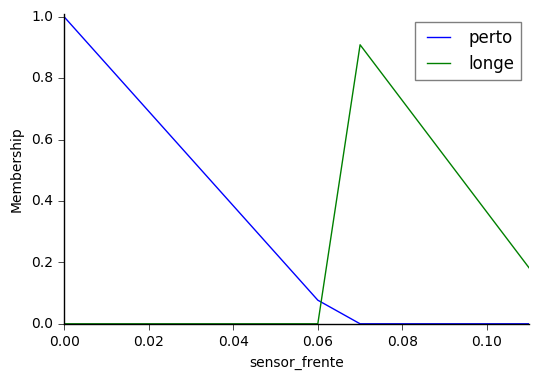

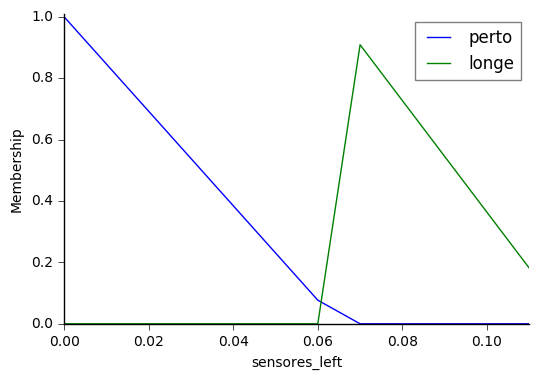

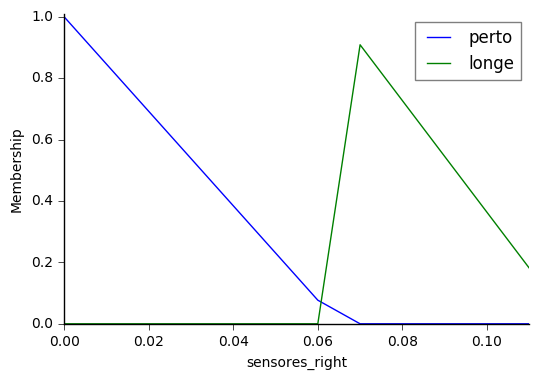

In [122]:
############################# INPUTS ################################

%matplotlib inline 
sensor_frente.view()
sensores_left.view()
sensores_right.view()

D:\Programas\Anaconda\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


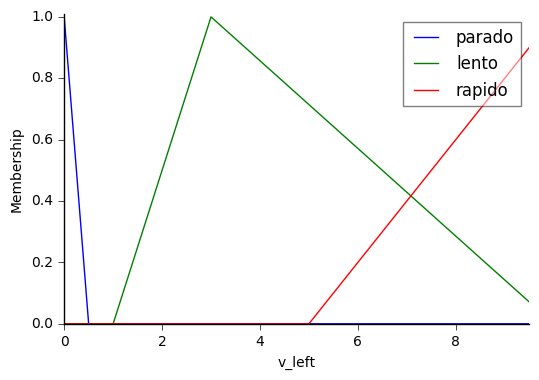

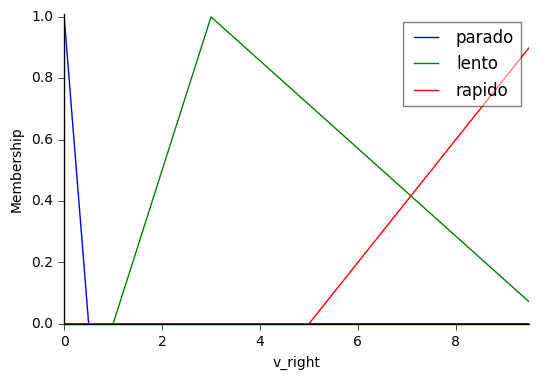

In [123]:
####################################### Outputs ####################################################
%matplotlib inline 
v_left.view()
v_right.view()

In [78]:
################################# controlando o Robô ##############################################################

while vrep.simxGetConnectionId(clientID != -1): #Enquanto houver conexão com o V-rep
    
    #Lê os sensores do robo e os coloca na lista de valores
    for i in range(5):
        error_code, estado, coord, detectedObjectHandle, detectedSurfaceNormalVector = vrep.simxReadProximitySensor(clientID,sensores_handle[i], vrep.simx_opmode_buffer)
        # Não sei pra que serve o estado, nem os dois últimos parametros retornados
        valores_sensores.append(coord[2]) # pega apenas cordenada Z que é a que importe de verdade
        
    # Sistema de controle fuzzy
    kjunior_ctrl = ctrl.ControlSystem([regra1,regra2,regra3,regra4]) #sistema de controle
    
    kjunior = ctrl.ControlSystemSimulation(kjunior_ctrl) #simulação do sistema de controle, pode-se criar vários para cada situação
    
    #Inputs para a simulação do K-junior
    kjunior.input['sensores_left'] = (valores_sensores[0] +  valores_sensores[1])/2 # tirei a média
    #kjunior.input['sensor_frente'] =  valores_sensores[2]
    kjunior.input['sensores_left'] = (valores_sensores[3] +  valores_sensores[4])/2

    # Processando a simulação do controle
    kjunior.compute()
    
    vl = kjunior.output['v_left']
    #vr = kjunior.output['v_right']
    
    # Passando as velocidades para o K-junior
    erro_code = vrep.simxSetJointTargetVelocity(clientID, leftMotorHandle, vl, vrep.simx_opmode_streaming)
    erro_code = vrep.simxSetJointTargetVelocity(clientID, leftMotorHandle, 99999999999999999, vrep.simx_opmode_streaming)
    
    print(2)
    print(vl)
    

2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.166666666667
2
0.1666666666

KeyboardInterrupt: 

# Teste apenas
kjunior_ctrl = ctrl.ControlSystem([regra1,regra2,regra3,regra4]) #sistema de controle
    
kjunior = ctrl.ControlSystemSimulation(kjunior_ctrl) #simulação do sistema de controle, pode-se criar vários para cada situação

#Inputs para a simulação do K-junior
kjunior.input['sensores_left'] = 0.02
#kjunior.input['sensor_frente'] = 0.02 Erro, não sei porque
kjunior.input['sensores_left'] = 0.02


### Processando a simulação do controle
kjunior.compute()

vl = kjunior.output['v_left']
vr = kjunior.output

### Passando as velocidades para o K-junior
erro_code = vrep.simxSetJointTargetVelocity(clientID, leftMotorHandle, vl, vrep.simx_opmode_streaming)
#erro_code = vrep.simxSetJointTargetVelocity(clientID, leftMotorHandle, vr, vrep.simx_opmode_streaming)

print(vr)
print(vl)